# Simulation de l'évolution de la stabilité des clusters

Ce notebook a pour objectif de simuler l'évolution de la **stabilité des clusters** créés à partir des données **RFM**, des **scores de satisfaction client** et des **méthodes de paiement**, sur différentes périodes.

L'algorithme de clustering utilisé est **K-Means**, et la stabilité des clusters est mesurée grâce à l'indicateur **Adjusted Rand Index (ARI)**. Cette simulation permet de suivre l'évolution des clusters toutes les deux semaines sur une période donnée, afin d'évaluer si la segmentation reste cohérente dans le temps.

Les résultats obtenus permettront de formuler des recommandations sur la **fréquence optimale** à laquelle il serait nécessaire de mettre à jour la segmentation pour maintenir une pertinence maximale.

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

In [2]:
# Charger les données
df = pd.read_csv('prepared_customer_data.csv')

# Afficher les premières lignes du dataframe pour vérifier le chargement
df.head()

,customer_unique_id,recency,frequency,total_spent,avg_review_score,product_variety,order_purchase_timestamp,payment_methods_boleto,payment_methods_credit_card,payment_methods_debit_card,payment_methods_not_defined,payment_methods_voucher
0,0000366f3b9a7992bf8c76cfdf3221e2,160.273507,1,141.90,5.0,1,2018-05-10 10:56:27,False,True,False,False,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163.263090,1,27.19,4.0,1,2018-05-07 11:11:27,False,True,False,False,False
2,0000f46a3911fa3c0805444483337064,585.850868,1,86.22,3.0,1,2017-03-10 21:05:03,False,True,False,False,False
3,0000f6ccb0745a6a4b88665a16c9f078,369.875428,1,43.62,4.0,1,2017-10-12 20:29:41,False,True,False,False,False
4,0004aac84e0df4da2b147fca70cf8255,336.905972,1,196.89,5.0,1,2017-11-14 19:45:42,False,True,False,False,False


## Simulation de l'évolution des clusters sur des périodes de 2 semaines

Dans cette section, nous simulons l'évolution de la stabilité des clusters au fil du temps en utilisant l'**ARI** (Adjusted Rand Index) comme mesure de divergence entre les clusters. L'objectif est d'analyser quand et comment les clusters évoluent, afin de déterminer le moment optimal pour réentraîner le modèle de clustering.

1. **Initialisation des paramètres :** Nous avons choisi de travailler avec **4 clusters**, ce nombre ayant été déterminé comme optimal à partir des résultats de la **méthode du coude** et du **Silhouette Score** obtenus dans le **notebook d'essais**.

2. **Mise à jour périodique des données :** Nous simulons l'évolution des clusters sur des périodes de deux semaines, en filtrant les nouvelles données au fur et à mesure, et en réentraînant le modèle à chaque intervalle. À chaque itération, les nouvelles données sont normalisées et intégrées dans le modèle, ce qui permet de recalculer l'ARI pour mesurer la divergence par rapport aux clusters de départ.

3. **Analyse de la stabilité :** L'ARI est calculé à chaque période pour comparer les clusters actuels avec ceux du départ. L'évolution de cet indice est tracée afin de visualiser comment la stabilité des clusters varie dans le temps. Ce suivi nous permet de formuler des recommandations concernant la **fréquence optimale de réentraînement** du modèle, afin de maintenir une segmentation pertinente.

In [3]:
# Assurer que la colonne 'order_purchase_timestamp'
#  est bien en format datetime
df['order_purchase_timestamp'] = pd.to_datetime(
    df['order_purchase_timestamp']
)

# Filtrer les données jusqu'au 01/01/2018
initial_date = '2018-01-01 00:00:00'
df_start = df.loc[df['order_purchase_timestamp'] < initial_date, :]

# Normalisation des données initiales (avant le 01/01/2018)
features_to_scale = [
    'recency', 'frequency', 'total_spent', 'avg_review_score',
    'payment_methods_boleto', 'payment_methods_credit_card',
    'payment_methods_debit_card', 'payment_methods_not_defined',
    'payment_methods_voucher'
]
scaler = MinMaxScaler()

df_startScaled = scaler.fit_transform(df_start[features_to_scale])

# Paramètres de la simulation
ncluster = 4  # Nombre de clusters
ari = []  # Liste pour stocker les scores ARI
simulation_start_date = '2018-01-01 00:00:00'  # Date de début

# Clustering initial avec les données normalisées
C0 = KMeans(n_clusters=ncluster, random_state=5).fit(df_startScaled)

# Créer un DataFrame pour la maintenance
# avec les données initiales normalisées
df_maintFinal = pd.DataFrame(df_startScaled, columns=features_to_scale)

In [4]:
# Filtrer les données futures (après 01/01/2018)
df_future = df.loc[df['order_purchase_timestamp'] >= simulation_start_date, :]

# Simulation de l'évolution des clusters sur des périodes de 2 semaines
"""
Cette boucle simule l'évolution des clusters dans le temps, en recalculant 
l'ARI toutes les deux semaines. Chaque itération met à jour les données, 
les normalise, réentraîne le modèle, et compare la stabilité des clusters 
avec l'ARI.
"""
while pd.to_datetime(simulation_start_date) < df[
    'order_purchase_timestamp'
].max():

    # Mettre à jour la date de début (+2 semaines)
    simulation_start_date = (
        pd.to_datetime(simulation_start_date) + pd.DateOffset(weeks=2)
    ).strftime('%Y-%m-%d %H:%M:%S')

    # Mettre à jour les données de maintenance (jusqu'à la nouvelle date)
    df_maint = df_future.loc[
        df_future['order_purchase_timestamp'] < simulation_start_date, :
    ]

    # Mettre à jour df_future avec les données après la nouvelle date
    df_future = df_future.loc[
        df_future['order_purchase_timestamp'] >= simulation_start_date, :
    ]

    # Normaliser les nouvelles données sans réajuster le scaler
    df_maintScaled = scaler.transform(df_maint[features_to_scale])

    # Ajouter les nouvelles données à notre DataFrame de maintenance
    df_maintFinal = pd.concat(
        [df_maintFinal, pd.DataFrame(
            df_maintScaled, columns=features_to_scale
        )]
    )

    # Recalculer le clustering sur toutes les données jusqu'à la date actuelle
    df_start = pd.concat([df_start, df_maint], axis=0)
    df_maintNew_scaled = scaler.transform(df_start[features_to_scale])

    # Effectuer un nouveau clustering
    C = KMeans(n_clusters=ncluster, random_state=5).fit(df_maintNew_scaled)

    # Calculer l'Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(
        C0.predict(df_maintFinal.to_numpy()),  # Convertir en tableau NumPy
        C.predict(df_maintNew_scaled)
    )
    ari.append(ari_score)

    # Afficher l'ARI pour la période
    print(f"ARI pour la période {simulation_start_date}: {ari_score:.4f}")

ARI pour la période 2018-01-15 00:00:00: 1.0000
ARI pour la période 2018-01-29 00:00:00: 1.0000
ARI pour la période 2018-02-12 00:00:00: 0.7654
ARI pour la période 2018-02-26 00:00:00: 0.7637
ARI pour la période 2018-03-12 00:00:00: 1.0000
ARI pour la période 2018-03-26 00:00:00: 1.0000
ARI pour la période 2018-04-09 00:00:00: 1.0000
ARI pour la période 2018-04-23 00:00:00: 1.0000
ARI pour la période 2018-05-07 00:00:00: 1.0000
ARI pour la période 2018-05-21 00:00:00: 1.0000
ARI pour la période 2018-06-04 00:00:00: 0.6264
ARI pour la période 2018-06-18 00:00:00: 0.6200
ARI pour la période 2018-07-02 00:00:00: 0.3916
ARI pour la période 2018-07-16 00:00:00: 0.9876
ARI pour la période 2018-07-30 00:00:00: 0.4024
ARI pour la période 2018-08-13 00:00:00: 0.5214
ARI pour la période 2018-08-27 00:00:00: 0.5159
ARI pour la période 2018-09-10 00:00:00: 0.5332
ARI pour la période 2018-09-24 00:00:00: 0.5159
ARI pour la période 2018-10-08 00:00:00: 0.9999
ARI pour la période 2018-10-22 00:00:00:

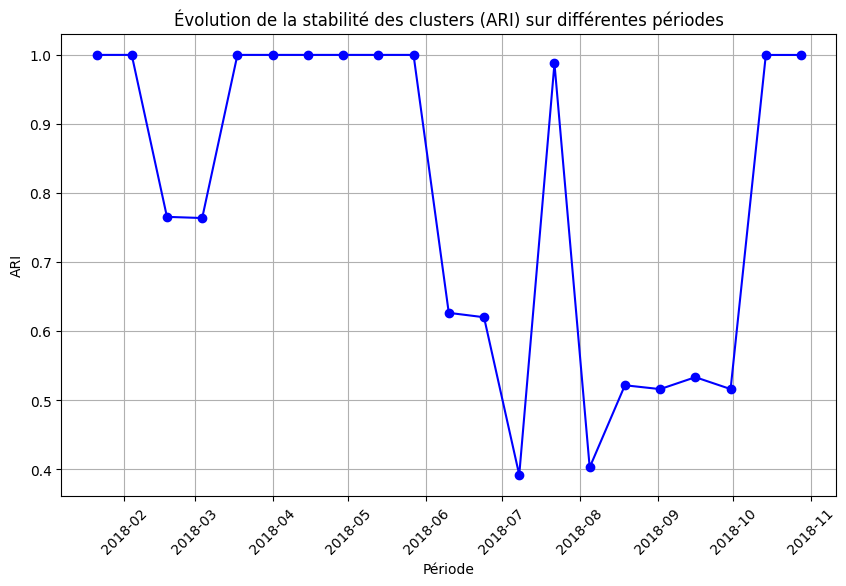

In [5]:
# Créer une liste des dates pour les périodes
dates = pd.date_range(start='2018-01-15', periods=len(ari), freq='2W')

# Tracer l'évolution du ARI
plt.figure(figsize=(10, 6))
plt.plot(dates, ari, marker='o', color='b')
plt.title(
    'Évolution de la stabilité des clusters (ARI) sur différentes périodes'
)
plt.xlabel('Période')
plt.ylabel('ARI')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Interprétation des résultats de l'ARI

Les résultats obtenus montrent une **stabilité globalement élevée des clusters** au fil des périodes, avec des valeurs d’**ARI** très proches de **1.0** pour la majorité des dates, indiquant une forte cohérence des clusters au fil du temps. Toutefois, certaines périodes révèlent une **baisse notable de l’ARI**, suggérant des changements significatifs dans la segmentation des clients. Voici les périodes concernées :

- **12 février 2018** (ARI = 0.7654)
- **4 juin 2018** (ARI = 0.6264)
- **2 juillet 2018** (ARI = 0.3916)
- **30 juillet 2018** (ARI = 0.4024)

Ces baisses de l’ARI signalent des moments où les données sous-jacentes ont probablement évolué, provoquant des divergences dans les clusters. Ce phénomène pourrait indiquer un besoin de **réévaluation du modèle de clustering** à ces dates pour conserver une segmentation pertinente et adaptée aux évolutions des comportements des clients.

Une analyse plus poussée de l’**évolution des distributions des features** sur ces périodes, avec des outils comme le **test de Kolmogorov-Smirnov**, permettrait d’identifier si ces variations ont contribué à la divergence des clusters, en vérifiant les changements dans les caractéristiques-clés comme la récence, la fréquence et le montant total dépensé.

In [12]:
# Liste mise à jour des features numériques à analyser
numeric_features = [
    'recency',
    'frequency',
    'total_spent',
    'avg_review_score',
    'product_variety'
]

# Périodes successives (exemple : bimensuel)
periods = pd.date_range(start='2018-01-01', end='2018-10-22', freq='2W')

# Initialisation des listes pour stocker les résultats
period_list = []
feature_list = []
ks_stat_list = []
p_value_list = []

# Comparer les distributions des features pour chaque période successivement
for i in range(len(periods) - 1):
    start_date = periods[i]
    end_date = periods[i + 1]

    # Filtrer les données pour chaque période
    data_period_1 = df[
        (df['order_purchase_timestamp'] >= start_date) &
        (df['order_purchase_timestamp'] < end_date)
    ]
    if i < len(periods) - 2:
        data_period_2 = df[
            (df['order_purchase_timestamp'] >= end_date) &
            (df['order_purchase_timestamp'] < periods[i + 2])
        ]
    else:
        # Dernière période comparée à la période juste avant
        data_period_2 = df[(df['order_purchase_timestamp'] >= end_date)]

    # Appliquer le test KS pour chaque feature
    for feature in numeric_features:
        ks_stat, p_value = ks_2samp(
            data_period_1[feature], data_period_2[feature]
        )

        # Stocker les résultats dans les listes
        period_list.append(
            f'{start_date.strftime("%Y-%m-%d")} - '
            f'{end_date.strftime("%Y-%m-%d")}'
        )
        feature_list.append(feature)
        ks_stat_list.append(ks_stat)
        p_value_list.append(p_value)

# Créer un DataFrame avec les résultats
ks_df = pd.DataFrame({
    'Période': period_list,
    'Feature': feature_list,
    'Statistique KS': ks_stat_list,
    'p-value': p_value_list
})

# Afficher le tableau des résultats
ks_df

,Période,Feature,Statistique KS,p-value
0,2018-01-07 - 2018-01-21,recency,1.000000,0.000000
1,2018-01-07 - 2018-01-21,frequency,0.001011,1.000000
2,2018-01-07 - 2018-01-21,total_spent,0.016939,0.732279
3,2018-01-07 - 2018-01-21,avg_review_score,0.015249,0.837780
4,2018-01-07 - 2018-01-21,product_variety,0.006464,1.000000
...,...,...,...,...
95,2018-09-30 - 2018-10-14,recency,1.000000,0.333333
96,2018-09-30 - 2018-10-14,frequency,0.500000,1.000000
97,2018-09-30 - 2018-10-14,total_spent,0.500000,1.000000
98,2018-09-30 - 2018-10-14,avg_review_score,0.500000,1.000000


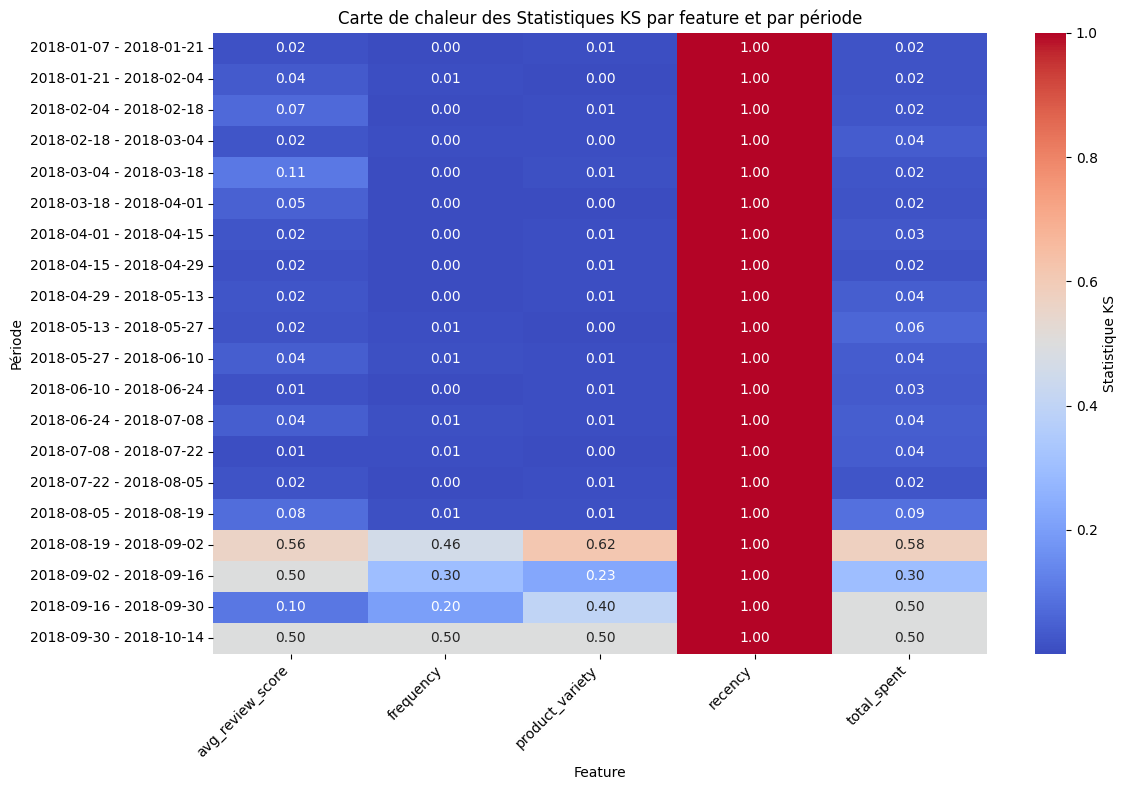

In [7]:
# Pivot le DataFrame pour avoir les périodes en lignes
# et les features en colonnes
ks_pivot = ks_df.pivot_table(
    index='Période', columns='Feature', values='Statistique KS'
)

# Créer une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    ks_pivot, annot=True, fmt=".2f", cmap='coolwarm',
    cbar_kws={'label': 'Statistique KS'}
)
plt.title('Carte de chaleur des Statistiques KS par feature et par période')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

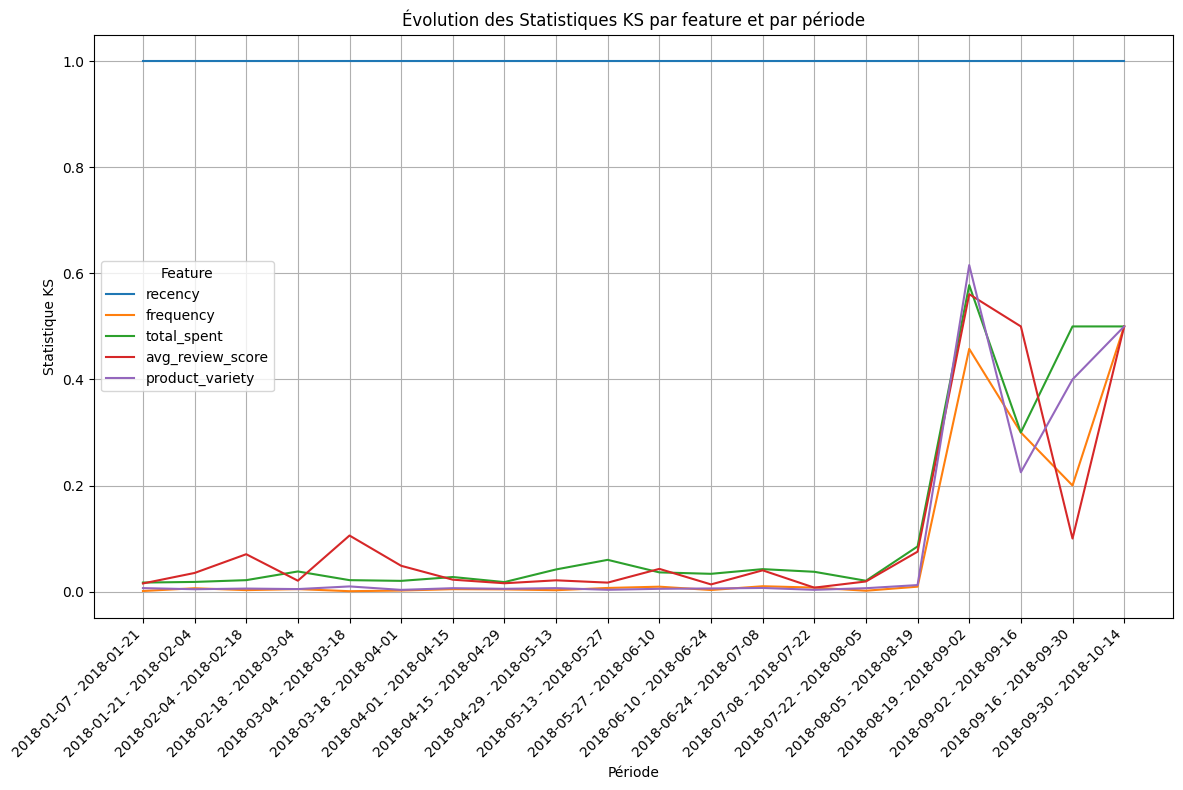

In [8]:
plt.figure(figsize=(12, 8))

# Boucler sur chaque feature et tracer la courbe des KS
for feature in ks_df['Feature'].unique():
    feature_data = ks_df[ks_df['Feature'] == feature]
    plt.plot(
        feature_data['Période'], feature_data['Statistique KS'], 
        label=feature
    )

plt.title('Évolution des Statistiques KS par feature et par période')
plt.xlabel('Période')
plt.ylabel('Statistique KS')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

## Interprétation des résultats du test Kolmogorov-Smirnov

Les résultats du **test de Kolmogorov-Smirnov (KS)** révèlent des variations dans les distributions des différentes caractéristiques au fil des périodes analysées. Voici une vue d’ensemble des comportements détectés pour chaque feature :

### Recency
- **Recency** a montré une **divergence maximale** (statistique KS = 1.0) pour toutes les périodes de **janvier à août 2018**, indiquant des changements constants et importants dans les comportements d'achat.
- Cependant, cette divergence se réduit à partir de **septembre 2018**, avec des p-values plus élevées, par exemple, **0.3333** pour la période du **30 septembre - 14 octobre**, signalant une légère stabilisation.

### Frequency
- **Frequency** est globalement stable avec des statistiques KS faibles (proches de 0) et des p-values élevées, proches de **1.0**, jusqu’en **août 2018**. 
- Une **divergence marquée** apparaît pour la période **19 août - 2 septembre 2018** (KS = 0.4577, p-value = 0.0483), montrant une variation significative de la fréquence d'achat pendant cette période.

### Total Spent
- Des **divergences modérées** sont observées pour **Total Spent** à plusieurs périodes, par exemple avec une statistique KS = **0.0598** et p-value = **0.0002** durant **13 mai - 27 mai 2018**.
- Une **forte divergence** apparaît sur la période du **19 août - 2 septembre 2018** (KS = 0.5778, p-value = 0.0048), signalant un changement important dans les montants dépensés.

### Avg Review Score
- Des variations significatives du **Avg Review Score** apparaissent, avec des statistiques KS plus élevées pour certaines périodes comme **4 mars - 18 mars 2018** (KS = 0.1057, p-value = 9.66e-16).
- Une autre période notable est **5 août - 19 août 2018** avec une statistique KS = **0.0752** et une p-value très basse (**1.69e-05**), suggérant des fluctuations notables dans la satisfaction client.

### Product Variety
- **Product Variety** est restée généralement stable, sauf pour certaines périodes. Une **divergence significative** est observée pour la période du **19 août - 2 septembre 2018** (KS = 0.6157, p-value = 0.00198), signalant des variations dans la diversité des achats.

### Résumé
Les périodes **août à septembre 2018** montrent des divergences accrues pour **Frequency**, **Total Spent**, **Avg Review Score**, et **Product Variety**, indiquant des changements importants dans le comportement client. Cette période pourrait bénéficier d’une mise à jour du modèle de segmentation pour maintenir la pertinence des clusters et mieux capturer les nouvelles dynamiques comportementales des clients.

## Conclusion et Recommandations pour la Maintenance de la Segmentation

L’analyse de la **stabilité des clusters** à travers l’**Adjusted Rand Index (ARI)** montre une segmentation cohérente sur la majorité des périodes, avec des valeurs d’ARI proches de **1.0**, signe de stabilité. Toutefois, des baisses notables de l’ARI, notamment autour des périodes du **4 juin, 2 juillet** et **30 juillet 2018**, signalent des moments où les caractéristiques des clients se sont éloignées des clusters d’origine, indiquant des variations dans leur comportement.

### Principales Observations du Test de Kolmogorov-Smirnov
Le test de **Kolmogorov-Smirnov (KS)** appliqué sur les différentes features révèle des divergences significatives dans certains comportements clients :
- **Recency** : Des changements constants de **janvier à août 2018** montrent des évolutions marquées dans les temps d’achat, avec une stabilisation partielle à partir de **septembre 2018**.
- **Total Spent** : Des variations notables apparaissent dès **mai 2018**, avec une forte divergence pour la période du **19 août - 2 septembre 2018**, suggérant des modifications dans les montants dépensés.
- **Avg Review Score** et **Product Variety** : Des fluctuations apparaissent également, en particulier durant **août 2018**, ce qui peut refléter des variations dans les préférences et la satisfaction des clients.

### Recommandations
Compte tenu des variations observées, il est recommandé de :
1. **Mettre à jour le modèle de segmentation tous les deux à trois mois** pour s’assurer que les clusters restent pertinents et alignés avec les comportements actuels des clients.
2. **Effectuer un suivi régulier des caractéristiques-clés**, en particulier **Recency** et **Total Spent**, pour détecter rapidement toute variation significative.
3. **Adapter les stratégies commerciales** en fonction des périodes où des divergences significatives sont relevées, notamment durant **août et septembre 2018**, afin de répondre aux évolutions des comportements clients.

Ces recommandations visent à optimiser la pertinence des segments dans le temps et à s’adapter aux changements du comportement client, en maintenant une segmentation à jour et en phase avec les données les plus récentes.